# Interpreting _Diffusion Models_ with `diffusers-interpret` 🧨🕵️‍♀️

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

`Diffusion` models are a class of generative models in machine learning that can be used for a wide range of tasks, including image and speech synthesis, video prediction, and more. `Diffusion` models are based on a probabilistic framework that allows for efficient and effective modeling of complex data distributions.

At a high level, diffusion models work by iteratively "_diffusing_" noise through a neural network, gradually transforming the noise into a sample from the target data distribution. This process is guided by a series of learned diffusion steps, where each step involves applying a series of transformations to the current sample, based on the current level of noise, to generate a new sample.

For a complete and comprehensive guide on diffusion models, [this is probably the best explanation out there](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/).

![disffusion_capi](samples/capybara.gif)

In this notebook, we will be using `stable-diffusion-v1-4`, provided by the [CompVis](https://huggingface.co/CompVis/stable-diffusion-v1-4) group. Below are the requirements for this particular notebook: 
 

````python

transformers>=4.21.1
setuptools>=49.6.0
torch>=1.9.1
diffusers~=0.3.0
scipy>=1.7.3
ftfy>=6.1.1
cmapy>=0.6.6
matplotlib>=3.5.3
opencv-python>=4.6.0
diffusers-interpret==0.4.0

````

If you are using Colab, use '!' instead of the '%'. 👌

In [ ]:
%pip install transformers>=4.21.1
%pip install setuptools>=49.6.0
%pip install torch>=1.9.1
%pip install diffusers~=0.3.0
%pip install scipy>=1.7.3
%pip install ftfy>=6.1.1
%pip install cmapy>=0.6.6
%pip install matplotlib>=3.5.3
%pip install opencv-python>=4.6.0
%pip install diffusers-interpret==0.4.0

Before we start and load the model, we need to log in to our hugging face account. To create one, follow [this link](https://huggingface.co/welcome). After we have an account, you will need to set your user access tokens (available in your personal account). If you have problems with this, follow [this tutorial](https://huggingface.co/docs/hub/security-tokens).

If you are usng `colab`, run the following lines to:

```python

from google.colab import output
output.enable_custom_widget_manager()

```

It costs $0 to create a HuggingFace account and generate an access token.

Now, just copy and paste your access token into the login screen above.

In [1]:
from huggingface_hub import notebook_login

from huggingface_hub import notebook_login
notebook_login()

Now, let us load the `StableDiffusionPipeline` and the `StableDiffusionPipelineExplainer`.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers_interpret import StableDiffusionPipelineExplainer

device = 'cpu'

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True,
    revision='fp16' if device != 'cpu' else None,
    torch_dtype=torch.float16 if device != 'cpu' else None
).to(device)

pipe.enable_attention_slicing()

explainer = StableDiffusionPipelineExplainer(pipe, gradient_checkpointing=True)

The generator below was written to make it possible to use it even without a GPU (or with a GPU that has too little VRAM).

In [3]:
from contextlib import nullcontext

prompt = "photo of a real capybara, shot on cannon dsrl, 50 mm lens, photojournalism, national geographic"

generator = torch.Generator(device).manual_seed(42)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=30, 
        generator=generator,
        height=448,
        width=448,
        n_last_diffusion_steps_to_consider_for_attributions=5
    )

  0%|          | 0/32 [00:00<?, ?it/s]

Calculating token attributions... Done!


Let's look at the generated image.

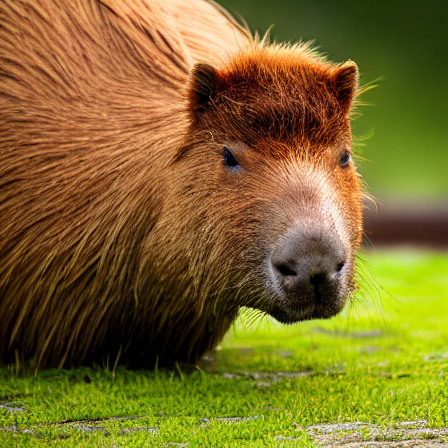

In [5]:
display(output.image)

Now let's look at the steps (noise removed filters) taken by the diffuser to generate our image.

- If you are using a jupyter notebook, you can view this transformation with the `output.all_images_during_generation.show()` function. 

- In colab, you can view the transform only as separate images or GIFs (`output.all_images_during_generation.gif()`).

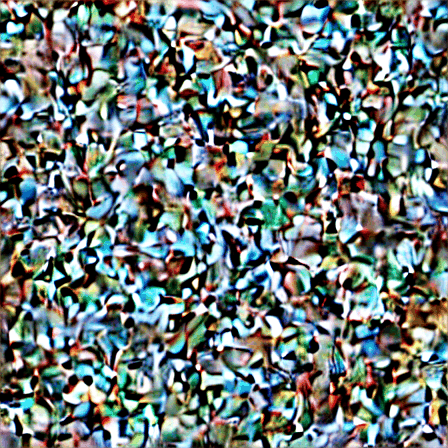

None

In [6]:
display(output.all_images_during_generation.gif(
    file_name="samples/diffusion_process.gif", duration=1))

We can get the normalized and unnormalized token attributions via the `output.token_attributions` and `output.normalized_token_attributions` methods. Attributions are the importances of each token in the prompt used to generate the image.

In [7]:
output.token_attributions

[('photo', 47.36992),
 ('of', 22.795172),
 ('a', 5.358827),
 ('real', 4.196989),
 ('cap', 8.724418),
 ('y', 95.278305),
 ('bara', 25.680105),
 (',', 29.289165),
 ('shot', 2.81298),
 ('on', 7.143308),
 ('cannon', 5.354914),
 ('ds', 1.9244738),
 ('rl', 2.8730552),
 (',', 1.8342426),
 ('5', 1.68455),
 ('0', 1.1947105),
 ('mm', 6.4082665),
 ('lens', 3.644517),
 (',', 2.1834092),
 ('photo', 2.1887698),
 ('journalism', 21.140688),
 (',', 1.4929084),
 ('national', 1.1320179),
 ('geographic', 11.364213)]

Below we create a function that generates an interpreter. The tokens most assigned by the model are colored red, yellow and blue in order of _"importance given by the model"_.

Prompt: "photo of a real capybara, shot on cannon dsrl, 50 mm lens, photojournalism, national geographic"



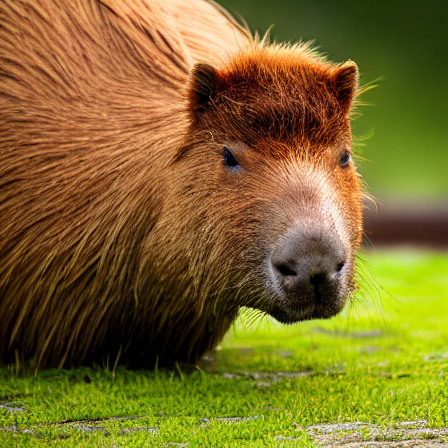

In [14]:
import matplotlib
import matplotlib.cm as cm
from IPython.display import HTML
import matplotlib.colors as mcolors


def interpret_output(prompt, output):
    print(f'Prompt: "{prompt}"\n')
    display(output.image)

    words, atributions = zip(*output.normalized_token_attributions)

    minima = min(atributions)
    maxima = max(atributions)

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.PiYG)

    colors = [mcolors.to_hex(mapper.to_rgba(v)) for v in atributions]

    text_with_attributions = ' '.join([f'''<span style="color:{colors[i]}"><b>{words[i]}</b></span>''' for i in range(len(words))])

    display(HTML(f'Attributions: {text_with_attributions}.'))

interpret_output(prompt, output) 

We could also plot these attribution scores per word as a `bar chart`.

In [15]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors

words, atributions = zip(*output.token_attributions)

words = [f'{i+1}_{word}' for i, word in enumerate(words)]

minima = min(atributions)
maxima = max(atributions)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.PiYG)

colors = [mcolors.to_hex(mapper.to_rgba(v)) for v in atributions]


import plotly.graph_objects as go

fig = go.Figure(go.Bar(
        x=atributions,
        y=words,
        orientation='h',
        marker_color=colors))
fig.update_xaxes(ticksuffix = "",
                griddash='dash')

fig.update_layout(
    template='plotly_dark',
    title_text=f'Atributions and Words',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    yaxis = dict(
      tickmode = 'linear',
      tick0 = 0.5,
      dtick = 0.75
   ))

fig.show()


According to this analysis, words (formed by the individual tokes) like "_capybara_" (the `directive` of the prompt) and "_photojournalism_" (the `modifier` of the prompt) had the biggest impact on the output of this model.

Tools like these can help us understand what models trained to generate synthetic data are _"doing"_ when processing our commands

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).